# Example geoSleuth Pipeline

This notebook is intended to walk through preprocessing, calculating, and analyzing a feature from inside the geoSleuth library. Before running, please make sure all data linked [here](https://www.dropbox.com/s/g7ax637zwsm0b3t/data.zip?dl=0) is in directory at the same level as this notebook. The data file is downloaded as a .zip and contains all data from Analyze Boston used for this project, along with the precomputed joined regions produced by `joinaroo.py`. This join is not rerun in this notebook, but all of the data is available so that `joinaroo.py` could be ran to rejoin the crime and region datasets. This notebook should be running in the same directory as the modules of geoSleuth. Please make sure all requirements listed in requirements.txt are installed and working correctly. Firstly, we'll need to import everything to be used throughout the process:

In [1]:
from calculations.base import DistCalc
from preprocessors.base import BaseProcessor
from analysis.base import BaseAnalyzer
import pandas as pd
import geopandas as gpd
import numpy as np

We'll first walk through calculating a distance feature. To do so, we'll define a function to be used to calculate distance feature values:

In [2]:
def inverse_square_sum(distances):
    result = 0
    for distance in distances:
        result += 1 / (distance ** 2)
    if result > 40:
        result = 40
    return result

We're ready to start the steps in the pipeline. First things first, we need to read in the shapefile of the feature. This is done using the `BaseProcessor` class, initialized with a class instance and passing in the filepath to the .shp:

In [3]:
filepath = "data/Boston_Police_Stations/Boston_Police_Stations.shp"
feature_df = BaseProcessor(filepath).data

Now we want to read in the precomputed subregions csv. We'll ask for a subset of the columns to see what a row of this Dataframe contains.

In [4]:
binned_crimes = pd.read_csv("data/crimes_in_bins.csv")
print(binned_crimes[["bin_id", "area_proportion", "OFFENSE_CODE_GROUP", "crime_point"]].head())

   bin_id  area_proportion               OFFENSE_CODE_GROUP  \
0       3         0.016062             Residential Burglary   
1       3         0.016062             Investigate Property   
2       3         0.016062                          Larceny   
3       3         0.016062  Motor Vehicle Accident Response   
4       3         0.016062                  Verbal Disputes   

                        crime_point  
0  POINT (-71.13862962 42.23346994)  
1  POINT (-71.13882916 42.23405146)  
2  POINT (-71.13882916 42.23405146)  
3  POINT (-71.13882916 42.23405146)  
4  POINT (-71.13882916 42.23405146)  


We see that this dataframe contains the bin_id, offense code group, and location of the crime in a row. We also see that not all crime points are unique, several occurred roughly in the same place. This is due to the fact that the level of granularity of reporting the location of the crime isn't extraordinarily larger the bins themselves.

## Feature Value Computation
We now have all the dataframes we need to run the distance feature calculation. `DistCalc` mandates a feature dataframe and the joined distribution and regions dataframe, but also takes in the optional argument of "feature_name" for labeling purposes if desired; this is useful for the .write_results() method for having a place to save results to.

In [5]:
calculator = DistCalc(feature_df, binned_crimes, feature_name="Police_min")
subgroups = ["Violent Crime", "Theft Crime"] # we'll use only these two subgroups for demonstration
results = calculator.calculation(subgroups, feature_function=min, group=True, to_file=False)
print("Result dict keys, should contain both passed in subgroups:")
print(str(list(results.keys())))

HERE
Result dict keys, should contain both passed in subgroups:
['Violent Crime', 'Theft Crime']


Let's check the actual results.

In [6]:
print(results["Violent Crime"].head())

   bin_id   feature  num_crimes  area_proportion  norm_crimes
0       3  1.719243           6         0.016062     0.096374
1       5  1.698519           1         0.089519     0.089519
2       6  1.646987          11         0.094711     1.041820
3       7  1.610385           2         0.090871     0.181741
4      12  1.483791           1         0.065567     0.065567


Hopefully we see a float value for feature, a crime count, the area proportion of the bin to its original census tract, and then the product of that proportion with the number of crimes for a single row. The calculator is working as expected if this is the case.

Let's run the calculator again, but with group=False.

In [7]:
results = calculator.calculation(subgroups, feature_function=min, group=False, to_file=False)
print(results["Violent Crime"].head())

    Unnamed: 0  bin_id  OBJECTID  area_proportion  \
9            3       3        21         0.016062   
21           3       3        21         0.016062   
25           3       3        21         0.016062   
28           3       3        21         0.016062   
36           3       3        21         0.016062   

                                             geometry  index_right  \
9   POLYGON ((-71.137478873173 42.23247514194577, ...        96633   
21  POLYGON ((-71.137478873173 42.23247514194577, ...       310972   
25  POLYGON ((-71.137478873173 42.23247514194577, ...       269709   
28  POLYGON ((-71.137478873173 42.23247514194577, ...       322668   
36  POLYGON ((-71.137478873173 42.23247514194577, ...       409892   

   INCIDENT_NUMBER  OFFENSE_CODE OFFENSE_CODE_GROUP DISTRICT SHOOTING  \
9       I182080619           802     Simple Assault      E18      NaN   
21      I162067177           802     Simple Assault      E18      NaN   
25      I172005018           802     Simp

In this case, without `group=True`, we merely append the feature value onto the row of the joinned crime and region dataframe. Not necessary for analysis, but might be interesting if curious about other information besides the count of crime.

## Analysis
Now it's time to analyze the results of our computation. Let's rerun the computation with grouping, and then initialize the analyzer object.

In [8]:
results = calculator.calculation(subgroups, feature_function=min, group=True, to_file=False)
analyzer = BaseAnalyzer(
results["Violent Crime"], "Sum of Region's 1/(r^2) Dist to Pol. Stations"
)

HERE


With the analyzer object initialized, we can now run some initial plotting. Let's just get a look at the data as a scatter plot first.

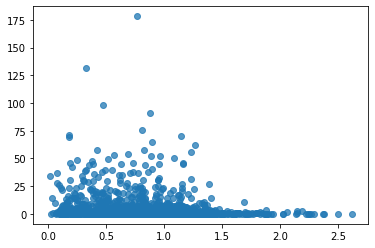

In [9]:
plt = analyzer.plot_raw("scatter", x_var="feature", y_var="norm_crimes")
plt.show()

The `.plot_raw()` method will plot a variety of types of plots for the computed data as an initial visualization. Its docstring can be viewed inside the analysis directory. Let's try another plot, the "agg" plot.

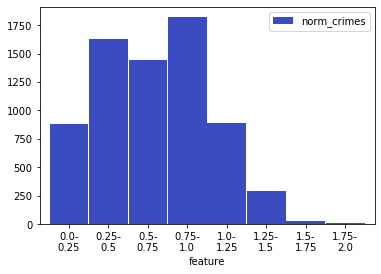

In [12]:
plt, ax = analyzer.plot_raw(
    "agg",
    bins=list(np.linspace(0,2, 9)),
    y_var="norm_crimes",
    ylabel="Sum of Crimes in Regions",
)
plt.show()

The `agg` plot is essentially a bar plot based on splitting the regions into ranges of feature values and then summing their crime counts. The result is seen above. We can now try to fit a model to the data.

Quadratic Regression R^2 Score: 0.04813090229252126


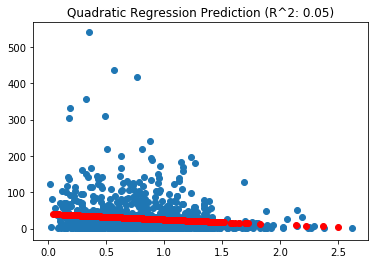

0.04813090229252126

In [13]:
analyzer.quadratic_model(plot=True)

Many points along the pipeline have been demonstrated, but all are documented inside the library.